In [32]:
import time
import json
from functools import wraps
from datetime import datetime
from datetime import date
from dateutil.relativedelta import relativedelta

import vk
import networkx as nx
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd

import numpy as np
from numpy.linalg import norm

from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score

In [4]:
cache_filename = 'graph_vertex_cache.json'

In [34]:
with open("author.txt") as f:
    login = f.readline().rstrip()
    passwd = f.readline().rstrip()

session = vk.AuthSession(app_id='6070120', user_login=login, user_password=passwd)

api = vk.API(session)
api_version = "5.73"


requests_count = 0

### Load graph dictionary from file if possible

In [6]:
try:
    cache_dict = json.load(open(cache_filename, 'r'))
except FileNotFoundError:
    cache_dict = {}
    
cache_dict = {int(k): val for k, val in cache_dict.items()}

### Construct a graph

In [7]:
# decorator that handles sleeping
def vk_requester(request_func):
    @wraps(request_func)
    def wrapper(*args, **kwargs):
        global requests_count
        if requests_count == 3:
            requests_count = 0
            time.sleep(1)
        try:
            requests_count += 1
            return_val = request_func(*args, **kwargs)
        except vk.exceptions.VkAPIError as err:
            if err.code in (6, 10): # too many requests per second or internal server error
                time.sleep(1)
                requests_count += 1
                return_val = request_func(*args, **kwargs)
            else:
                raise err
        return return_val
    return wrapper

In [8]:
def request_list(request_func):
    @wraps(request_func)
    def wrapper(*args, **kwargs):
        return_val = request_func(*args, **kwargs)
        if isinstance(return_val, list):
            return return_val
        else:
            return list(return_val['items'])
    return wrapper

def handle_friends_exceptions(request_func):
    @wraps(request_func)
    def wrapper(*args, **kwargs):
        try:
            return_val = request_func(*args, **kwargs)
        except vk.exceptions.VkAPIError as err:
            if err.code == 18: # deleted or banned user
                return_val = []
            else:
                raise err
        return return_val
    return wrapper

In [9]:
@request_list
@handle_friends_exceptions
@vk_requester
def get_friends(api, api_version, user_id):
    return api.friends.get(user_id=user_id, v=api_version)

In [237]:
def construct_graph(user_id, output_graph, api, waves=3):
    output_graph.add_node(user_id)
    
    # request friends
    global cache_dict

    if user_id in cache_dict:
        friends = cache_dict[user_id]
    else:
        #print("{} not found in cache".format(user_id))
        friends = get_friends(api, api_version, user_id)
        cache_dict[user_id] = friends

    # add each friendship and dive deeper
    for friend in friends:
        friend_in_graph = friend in output_graph.nodes()
        if waves != 0 and not friend_in_graph:
            global nodes_waves
            nodes_waves[waves - 1].append(friend)

            construct_graph(friend, output_graph, api, waves - 1)

        if waves == 0 and not friend_in_graph:
            continue

        output_graph.add_edge(user_id, friend)


In [11]:
class MyCoolException(Exception):
    pass

In [14]:
start_id = 10938483 # my id
waves = 4

In [ ]:
%%time
main_graph = nx.Graph()
nodes_waves = {wave: [] for wave in range(waves + 1)}

while True:
    try:
        construct_graph(start_id, main_graph, api, waves)
        raise MyCoolException()
    except Exception as err:
        if isinstance(err, MyCoolException):
            break

            
#graph_from_cache(start_id, main_graph)

nodes_waves = {waves - key: val for key, val in nodes_waves.items()}

In [25]:
len(main_graph.nodes())

6404472

In [77]:
'''
with open(cache_filename, 'w') as f:
    json.dump(cache_dict, f)
'''

In [232]:
def graph_from_cache(user_id, output_graph, waves=3):
    global nodes_waves
    
    output_graph.add_node(user_id)
    
    if user_id in cache_dict:
        friends = cache_dict[user_id]
        for friend in friends:
            friend_in_graph = friend in output_graph.nodes()
            if waves != 0 and not friend_in_graph:
                global nodes_waves
                nodes_waves[waves - 1].append(friend)
                
                graph_from_cache(friend, output_graph, waves - 1)
            
            if waves == 0 and not friend_in_graph:
                continue
                
            output_graph.add_edge(user_id, friend)

In [233]:
%%time

waves = 2
nodes_waves = {wave: [] for wave in range(waves + 1)}

graph_piece = nx.Graph()
graph_from_cache(start_id, graph_piece, waves)

nodes_waves = {waves - key: val for key, val in nodes_waves.items()}
nodes_waves[0] = [start_id]

CPU times: user 472 ms, sys: 31.2 ms, total: 503 ms
Wall time: 952 ms


In [ ]:
main_graph = nx.Graph()
graph_from_cache(start_id, main_graph, 4)

In [167]:
len(main_graph)

1

In [229]:
len(graph_piece)

3689

### Visualize the graph

In [235]:
%%time
pos=nx.shell_layout(graph_piece, list(map(lambda x: x[1], sorted(nodes_waves.items(), reverse=True))))

CPU times: user 3.84 ms, sys: 7.82 ms, total: 11.7 ms
Wall time: 21.8 ms


In [163]:
colors = ['#f20000', '#f0e000', '#097505', '#07edb3', '#0791ed', '#0716ed', '#9d08a8']

CPU times: user 1.13 s, sys: 268 ms, total: 1.4 s
Wall time: 1 s


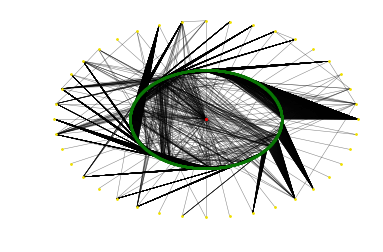

In [253]:
%%time
#nx.draw(main_graph, pos=pos, node_color='pink', edge_color='black', node_size=1)

def draw_graph_waves(graph, pos, nodes_waves, filename):
    for wave, nodes in sorted(nodes_waves.items(), reverse=True):
        nx.draw_networkx_nodes(graph, pos, nodelist=nodes, node_color=colors[wave], node_size=5 - 2 * wave)
    nx.draw_networkx_edges(graph, pos, width=0.5, alpha=0.5)

    plt.axis('off')
    plt.savefig("{}.pdf".format(filename), orientation='portrait', transparent=False, bbox_inches=None, pad_inches=0.1) 

draw_graph_waves(graph_piece, pos, nodes_waves, 'graph')

### Form dataset from graph nodes

In [27]:
@vk_requester
def get_users(api, api_version, user_ids, fields):
    return api.users.get(user_ids=user_ids, fields=fields, v=api_version)

In [28]:
@request_list
@vk_requester
def get_groups(api, api_version, user_ids, fields):
    return api.groups.get(user_ids=user_ids, extended=1, fields=fields, v=api_version)

In [223]:
features_fields = ['uid', 'first_name', 'last_name', 'deactivated', 
                   'bdate', 'city', 'country', 'home_town', 
                   'universities', 'schools', 'relation', 'counters']
counters = ['audios', 'friends', 'photos', 'videos', 'groups']

features = ['first_name', 'last_name', 'is_active', 'age', 'education', 
            'has_age', 'has_education', 'has_location'] 
features += list(map(lambda x: 'cnt_{}'.format(x), counters)) + ['avg_group_size', 'avg_friend_degree', 'wave']

def create_dataset(graph, nodes_data):
    node_ids = list(graph.nodes())
    for node_id in node_ids:
        
        if node_id in nodes_data.index:
            continue
            
        user = get_users(api, api_version, node_id, features_fields)[0]

        f = {feature: np.nan for feature in nodes_data.columns}
        # generate features from acquired fields
        if 'first_name' in user:
            f['first_name'] = user['first_name']

        if 'last_name' in user:
            f['last_name'] = user['last_name']

        if 'deactivated' in user:
            f['is_active'] = 0

        if 'bdate' in user:
            try:
                f['age'] = relativedelta(date.today(), datetime.strptime(user['bdate'], '%d.%m.%Y').date()).years
            except:
                pass
            f['has_age'] = 1
        else:
            f['has_age'] = 0

        if 'universities' in user:
            f['education'] = 'higher'
            f['has_education'] = 1
        elif 'schools' in user:
            f['education'] = 'secondary'
            f['has_education'] = 1
        else:
            f['has_education'] = 0

        if any (field in user for field in ('city', 'country', 'home_town')):
            f['has_location'] = 1
        else:
            f['has_location'] = 0

        if 'counters' in user:
            for counter in counters:
                if counter in user['counters']:
                    f['cnt_{}'.format(counter)] = user['counters'][counter]

        groups = get_groups(api, api_version, node_id, fields=['gid', 'members_count'])
        groups = list(group['members_count'] for group in groups if 'members_count' in group)
        f['avg_group_size'] = sum(groups) / len(groups)

        neighbours_degrees = list(map(lambda x: graph.degree[x], list(graph.neighbors(node_id))))
        f['avg_friend_degree'] = sum(neighbours_degrees) / len(neighbours_degrees)
        
        f['wave'] = [wave for wave, nodes in nodes_waves.items() if node_id in nodes][0]
        
        nodes_data.loc[node_id] = tuple(f[key] for key in features)

In [77]:
nodes_data = pd.DataFrame(columns=features)

In [224]:
%%time
create_dataset(graph_piece, nodes_data)

CPU times: user 1.42 s, sys: 93 µs, total: 1.42 s
Wall time: 1.42 s


In [225]:
nodes_data.head()

,first_name,last_name,is_active,age,education,has_age,has_education,has_location,cnt_audios,cnt_friends,cnt_photos,cnt_videos,cnt_groups,avg_group_size,avg_friend_degree,wave
10938483,Maria,Sindeeva,NaN,20,higher,1,1,1,681,115,284,27,51,58860.173913,35.313043,0.0
280452,Lilya,Kozlova,NaN,NaN,higher,0,1,1,0,960,60,211,NaN,58860.173913,1.119247,1.0
5033,Anastasia,Vlasova,NaN,117,NaN,1,0,1,0,285,550,58,NaN,58860.173913,956.000000,2.0
7523,Lena,Linkova,NaN,117,NaN,1,0,1,135,659,1021,26,NaN,58860.173913,956.000000,2.0
11797,Anna,Ivanova,NaN,28,NaN,1,0,1,172,375,158,11,82,58860.173913,956.000000,2.0


In [ ]:
%%time
while True:
    try:
        create_dataset(graph_2waves, nodes_data)
        raise MyCoolException()
    except Exception as err:
        if isinstance(err, MyCoolException):
            break

### Apply clustering to the data

In [246]:
def spectral_cluster(graph, k_clusters):
    adjacency = nx.adjacency_matrix(graph)

    cl = SpectralClustering(n_clusters=k_clusters, affinity='precomputed').fit(adjacency)
    
    labels_nodes = {}
    for label in cl.labels_:
        labels_nodes[label] = [node_id for ind, node_id in enumerate(graph.nodes()) if cl.labels_[ind] == label]
        
    return labels_nodes

In [255]:
%%time
labels_nodes = spectral_cluster(graph_piece, 3)

CPU times: user 3.82 s, sys: 1.64 s, total: 5.45 s
Wall time: 3.33 s


In [258]:
{label: len(nodes) for label, nodes in labels_nodes.items()}

{0: 3687, 1: 1, 2: 1}

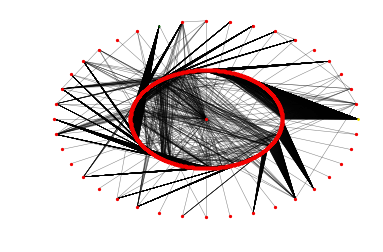

In [259]:
draw_graph_waves(graph_piece, pos, labels_nodes, 'graph_3')

In [ ]:
%%time
#adjacency = smth
    
'''
silhouettes = {}
for k in range(2, 10):
    fit_clustering = SpectralClustering(n_clusters=k, affinity='precomputed').fit(adjacency)
    silhouettes[k] = (silhouette(k, adjacency, fit_clustering.labels_), fit_clustering)
'''

clusterings = []
for k in range(2, 10):
    cl = SpectralClustering(n_clusters=k, affinity='precomputed').fit(adjacency)
    
    labels_nodes = {}
    for label in cl.labels_:
        labels_nodes[label] = [node_id for ind, node_id in enumerate(main_graph.nodes()) if cl.labels_[ind] == label]
    
    
print(max(clusterings, key = lambda clustering: silhouette_score(adjacency, clustering.labels_)))

In [49]:
clusterings

[SpectralClustering(affinity='precomputed', assign_labels='kmeans', coef0=1,
           degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
           kernel_params=None, n_clusters=2, n_init=10, n_jobs=1,
           n_neighbors=10, random_state=None),
 SpectralClustering(affinity='precomputed', assign_labels='kmeans', coef0=1,
           degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
           kernel_params=None, n_clusters=3, n_init=10, n_jobs=1,
           n_neighbors=10, random_state=None),
 SpectralClustering(affinity='precomputed', assign_labels='kmeans', coef0=1,
           degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
           kernel_params=None, n_clusters=4, n_init=10, n_jobs=1,
           n_neighbors=10, random_state=None),
 SpectralClustering(affinity='precomputed', assign_labels='kmeans', coef0=1,
           degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
           kernel_params=None, n_clusters=5, n_init=10, n_jobs=1,
           n_neighbors=

In [29]:
'''
DEPRECATED IN FAVOUR OF DECORATORS
'''
def get_friends_with_sleep(user_id):
    global requests_count
    if requests_count == 3: # avoid making too many requests
        requests_count = 0
        time.sleep(1)

    try:
        friends = api.friends.get(user_id=user_id, v=api_version)
        requests_count += 1
    except vk.exceptions.VkAPIError as err:
        if err.code in (6, 10): # too many requests per second or internal server error
            time.sleep(1)
            friends = get_friends_with_sleep(user_id)
        else:
            raise err
    if isinstance(friends, list):
        return friends
    return friends['items']

In [36]:
'''
DEPRECATED
'''

def silhouette(k_clusters, data, labels):
    
    s = []
    for vec_ind, vec in enumerate(data):
        vec_cluster = labels[vec_ind]
        b_i = []
        a_i = 0
        for cl_num in range(k_clusters):
            metric = np.average([norm(vec - cl_vec) for cl_vec_ind, cl_vec in enumerate(data) if labels[cl_vec_ind] == cl_num])
            if vec_cluster == cl_num:
                a_i = metric
            else:
                b_i.append(metric)
        b_i = min(b_i)
        
        s_i = (b_i - a_i) / max(a_i, b_i)
        s.append(s_i)
    
    return np.average(s)